In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision import transforms
import torchvision
import torchsummary

from networks.generator import ResNetGenerator

In [21]:
simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
mnist_trainset = datasets.MNIST(root='./datasets/mnist', train=True, download=True, transform=simple)

In [9]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [49]:
class Mnistdenoizing_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):        
        self.mnist_dataset = dataset
        
    def __getitem__(self, idx):
        img = self.mnist_dataset[idx][0][0]
        noise = np.random.random((28, 28)).astype(np.float32)
        img_w_noise = img + torch.tensor(noise)
        return torch.unsqueeze(img, 0).type(torch.double), torch.unsqueeze(img_w_noise, 0).type(torch.double)
    
    def __len__(self):
        return len(self.mnist_dataset)

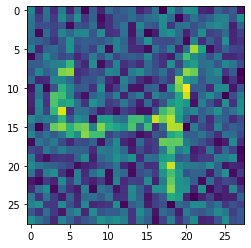

In [56]:
mnist_noise_dataset = Mnistdenoizing_dataset(mnist_trainset)
train_set, val_set = torch.utils.data.random_split(mnist_noise_dataset, [1000, 59000])

mnist_loader = DataLoader(mnist_trainset, batch_size=2,)
mnist_noise_loader = DataLoader(mnist_noise_dataset, batch_size=3)
for img, image_noise in mnist_noise_loader:
    plt.imshow(image_noise[2][0])
    plt.show()
    break

In [57]:
model = ResNetGenerator(c_dim=1, kernel_size=3, repeat_num=2)
# nn.init.xavier_normal(model.parameters())
# resnet = torchvision.models.resnet18()
torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           3,136
            Conv2d-2           [-1, 64, 28, 28]           3,136
    InstanceNorm2d-3           [-1, 64, 28, 28]             128
    InstanceNorm2d-4           [-1, 64, 28, 28]             128
              ReLU-5           [-1, 64, 28, 28]               0
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 14, 14]          73,728
            Conv2d-8          [-1, 128, 14, 14]          73,728
    InstanceNorm2d-9          [-1, 128, 14, 14]             256
   InstanceNorm2d-10          [-1, 128, 14, 14]             256
             ReLU-11          [-1, 128, 14, 14]               0
             ReLU-12          [-1, 128, 14, 14]               0
DownsamplingBlock-13          [-1, 128, 14, 14]               0
DownsamplingBlock-14          [-1, 128,

In [58]:
BATCH_SIZE = 5
criterian = nn.MSELoss()
def train(model, dataset, num_epoch=32, gd=None):
    model.double()
    if gd is None:
        gd = optim.Adam(model.parameters(), lr=0.01)
    
    dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
#     dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
#     scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, batch in enumerate(dataloader):
#             print(i)
            gd.zero_grad()
#             img = torch.tensor(batch[0], dtype=torch.double, requires_grad=True)
#             img_noise = torch.tensor(batch[1], dtype=torch.double, requires_grad=True)
            batch[0].requires_grad = True
            
            batch[1].requires_grad = True
            f = model(batch[0])
#             print(img_noise.shape)
            loss = criterian(batch[1], f)
#             return batch
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
#             if i == 2000:
#                 break
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
#         for i, (batch) in enumerate(dataloader_test):
#             batch = batch.to(device=device)
#             scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
#         test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}")

In [59]:
train(model, mnist_noise_dataset)

1, Train loss: 0.317239230005616
2, Train loss: 0.3142157691322865
3, Train loss: 0.3143621743294133
4, Train loss: 0.3144141610665518
5, Train loss: 0.31401600645856326
6, Train loss: 0.31429604528064387
7, Train loss: 0.3146241350483867
8, Train loss: 0.31520657837911026
9, Train loss: 0.3142684421650919
10, Train loss: 0.3150487802269205
11, Train loss: 0.3143673048346844
12, Train loss: 0.31464067886363173
13, Train loss: 0.31429330177293535


KeyboardInterrupt: 

In [ ]:
model(torch.tensor(mnist_noise_dataset[0][0], dtype=torch.float, requires_grad=True))

In [7]:
class NetworkBase(nn.Module):
    def __init__(self):
        super(NetworkBase, self).__init__()
        self._name = 'BaseNetwork'

    @property
    def name(self):
        return self._name

    def init_weights(self):
        self.apply(self._weights_init_fn)

    def _weights_init_fn(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
            if hasattr(m.bias, 'data'):
                m.bias.data.fill_(0)
        elif classname.find('BatchNorm2d') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def _get_norm_layer(self, norm_type='batch'):
        if norm_type == 'batch':
            norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
        elif norm_type == 'instance':
            norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)
        elif norm_type == 'batchnorm2d':
            norm_layer = nn.BatchNorm2d
        else:
            raise NotImplementedError('normalization layer [%s] is not found' % norm_type)

        return norm_layer

    def forward(self, *input):
        raise NotImplementedError

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class ResidualBlock(nn.Module):
    """Residual Block."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True))

    def forward(self, x):
        return x + self.main(x)


class ResNetGenerator1(nn.Module):
    """Generator. Encoder-Decoder Architecture."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=9, k_size=4, n_down=2):
        super(ResNetGenerator1, self).__init__()
        self._name = 'resnet_generator'

        layers = []
        layers.append(nn.Conv2d(c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-Sampling
        curr_dim = conv_dim
        for i in range(n_down):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=k_size, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-Sampling
        for i in range(n_down):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=k_size, stride=2, padding=1,
                                             output_padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 1, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())

        self.model = nn.Sequential(*layers)

    def forward(self, x, c=None):
        if c is not None:
            # replicate spatially and concatenate domain information
            c = c.unsqueeze(2).unsqueeze(3)
            c = c.expand(c.size(0), c.size(1), x.size(2), x.size(3))
            x = torch.cat([x, c], dim=1)
        return self.model(x)

In [23]:
m = ResNetGenerator1()
torchsummary.summary(m, (5, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          15,680
    InstanceNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 128, 14, 14]         131,072
    InstanceNorm2d-5          [-1, 128, 14, 14]             256
              ReLU-6          [-1, 128, 14, 14]               0
            Conv2d-7            [-1, 256, 7, 7]         524,288
    InstanceNorm2d-8            [-1, 256, 7, 7]             512
              ReLU-9            [-1, 256, 7, 7]               0
           Conv2d-10            [-1, 256, 7, 7]         589,824
   InstanceNorm2d-11            [-1, 256, 7, 7]             512
             ReLU-12            [-1, 256, 7, 7]               0
           Conv2d-13            [-1, 256, 7, 7]         589,824
   InstanceNorm2d-14            [-1, 25